<a href="https://colab.research.google.com/github/kimberley-faria/implicit-hate-detection/blob/main/implicit_hate_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

setup a git repo in your google drive - https://medium.com/analytics-vidhya/how-to-use-google-colab-with-github-via-google-drive-68efb23a42d

(I did this in a separate notebook, so I can keep this one free of git commit/push etc commands)

In [1]:
# if local
!conda activate cs685

/bin/bash: conda: command not found


In [2]:
BASE_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection'
DATA_PATH = '/content/drive/MyDrive/685-NLP-Project/implicit-hate-corpus'

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import sys
os.path.dirname(sys.executable)

'/usr/bin'

In [5]:
import sys

if 'google.colab' in sys.modules:
    from google.colab import drive
    drive.mount('/content/drive')
    base_path = BASE_PATH
else:
    base_path = r'C:\Users\faria\PycharmProjects\685\project\implicit-hate-detection'
    DATA_PATH = r'C:\Users\faria\PycharmProjects\685\project\data\implicit-hate-corpus-nov-2021\implicit-hate-corpus'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


switch to the git repo in your drive

In [6]:
%cd $base_path
# !git checkout 5-bert-baselines-bin-classification-hate-non-hate

/content/drive/MyDrive/685-NLP-Project/implicit-hate-detection


In [7]:
# !git status

install requirements from repo 

In [8]:
# for colab, use venv if in local
!pip install -r requirements.txt
!pip3 install emoji

     |████████████████████████████████| 4.2 MB 7.3 MB/s 
     |████████████████████████████████| 1.8 MB 41.6 MB/s 
     |████████████████████████████████| 6.6 MB 11.1 MB/s 
     |████████████████████████████████| 84 kB 3.6 MB/s 
     |████████████████████████████████| 596 kB 62.0 MB/s 
     |████████████████████████████████| 181 kB 68.5 MB/s 
     |████████████████████████████████| 145 kB 56.9 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=391498ce623ea59b6a1e752f4a30dedd97c7f5a1900195ee8d2a23eeab5e844d
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 175 kB 8.5 MB/s 
  Created wheel for emoji: filename=emoji-1.

load the helper and dataloader files

In [9]:
%load implicit_hate_dataloader/dataloader.py    
%load implicit_hate_dataloader/helpers.py

In [10]:
import torch
assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla P100-PCIE-16GB, n_gpu: 1


In [11]:
import numpy as np
import random
from transformers.file_utils import is_tf_available, is_torch_available, is_torch_tpu_available
import os


def set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).

    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if is_torch_available():
      torch.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)
      torch.backends.cudnn.deterministic = True
      torch.backends.cudnn.benchmark = False
      os.environ['PYTHONHASHSEED'] = str(seed)
      # safe to call this function even if cuda is not available
    if is_tf_available():
      import tensorflow as tf
      tf.random.set_seed(seed)

set_seed(70)

In [12]:
data_path = DATA_PATH
dataset_filename = {
    # post (str)
    # class (str): high-level label in {`explicit_hate`,`implicit_hate`,`not_hate`}
    "stage-1": os.path.join(data_path, "implicit_hate_v1_stg1_posts.tsv"),

    # post (str)
    # class (str): fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`}
    # extra_implicit_class: (str) A secondary fine-grained implicit hate label in
    # {`white_grievance`, `incitement`, `inferiority`, `irony`, `stereotypical`, `threatening`, `other`, **None**}
    "stage-2": os.path.join(data_path, "implicit_hate_v1_stg2_posts.tsv"),

    # post (str)
    # target: (str) Free-text annotation for the group being targeted (e.g. `Black people`, `Immigrants`, etc.)
    # implied_statement: (str) Free-text annotation for the implicit or hidden underlying meaning of the post made
    # explicit (e.g. `people in minority groups are all in gangs`)
    "stage-3": os.path.join(data_path, "implicit_hate_v1_stg3_posts.tsv")
}

In [13]:
from implicit_hate_dataloader.dataloader import Stage1Dataset, Stage2Dataset
from torch.utils.data import DataLoader

In [14]:
from sklearn.model_selection import train_test_split
import numpy as np

implicit_hate_dataset = Stage2Dataset(dataset_filename["stage-2"], drop_other=True, bertweet=True)

labels = implicit_hate_dataset.implicit_classes
# splitting into train and test set
train_idx, test_idx= train_test_split(np.arange(len(labels)), test_size=0.2, shuffle=True, stratify=labels)
print(len(labels), len(train_idx), len(test_idx))
train_idx.sort()
print(np.arange(len(labels)))
print(train_idx)

# splitting into train and val set from train indices 
train_labels = list(map(labels.__getitem__, train_idx))
train_idx, val_idx= train_test_split(train_idx, test_size=0.25, shuffle=True, stratify=train_labels)
print(len(train_idx), len(val_idx))

train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_idx)
test_sampler = torch.utils.data.SubsetRandomSampler(test_idx)

train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

# test_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=test_sampler)

Downloading:   0%|          | 0.00/558 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/824k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


6266 5012 1254
[   0    1    2 ... 6263 6264 6265]
[   0    1    2 ... 6260 6262 6265]
3759 1253


In [15]:
# Confirming type is tensor
text, _, _, input_ids, attention_masks, labels, _ = next(iter(train_dataloader))
print(type(input_ids), type(attention_masks), type(labels))

print(text)

<class 'torch.Tensor'> <class 'torch.Tensor'> <class 'torch.Tensor'>
(' if you\'re white  you don\'t need to  " join " " anything . your skin is your uniform . have white children and teach the our culture "', "it's mexifornia, land of hemp fields and socialistsvery anti-citizen and pro-illegals", 'close border, or bring our soldiers back home to protect the taxpayers!', ': and as poor as they are  the predominantly white areas are still safer .', 'may he rest in peace . i didnt know him  i bet he was a good man . stood for what was right  the white race .', "so is the white hating  jew hating cult  the nation of islam . what's your point ?", ' european  " refugee " " crisis worsens #wakeupamerica #whitelivesmatter "', 'it seems people are willing to sell the future of western children for a momentary feeling of misguided moral superiority .')


In [16]:
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
# function to get validation accuracy
def get_validation_performance(model, val_idx, config, epoch, dataset):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    sampler = torch.utils.data.SubsetRandomSampler(val_idx)
    validation_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=sampler)

    total_correct = 0

    predicted = []
    labels = []

    for batch in validation_dataloader:

      input_id_tensors = batch[3]
      input_mask_tensors = batch[4]
      label_tensors = batch[5]
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()
        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
        predicted.append(pred_flat)
        labels.append(labels_flat)      

        
    predicted = np.concatenate(predicted)
    labels = np.concatenate(labels)

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_idx)
    final_score = precision_recall_fscore_support(predicted, labels, average='macro')
    class_names=['white_grievance', 'incitement', 'inferiority', 'irony', 'stereotypical', 'threatening']
    wandb.log({f"conf_mat_{dataset}_{epoch}" : wandb.plot.confusion_matrix(probs=None,
                        y_true=labels, preds=predicted,
                        class_names=class_names)})
    cm = confusion_matrix(labels, predicted, labels=[0, 1, 2, 3, 4, 5])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=class_names)
    disp.plot()

    wandb.log({f"conf_mat_matplotlib_{dataset}_{epoch}": plt})
    plt.show()

    return avg_val_accuracy, final_score

In [17]:
!wandb login

wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [18]:
import wandb

# hyperparameters used in original paper
sweep_config = {
    "name": "implicit_hate_detection_multi_class_bertweet_and_sarc",
    "method" : "grid",
    "parameters" : {
        "batch_size": {
            "values" : [8]
        },
        "learning_rate" : {
            "values": [1e-5, 2e-5, 3e-5, 4e-5]
        },
        "random_seed" : {
          "values": [37, 69, 42]    
        },

        "epochs" : {
            "values" : [3]
        },
        "epsilon": {
            "values" : [1e-8]
        },
    }
}

sweep_id = wandb.sweep(sweep_config, entity="umass-iesl-is", project="bertweet-sarc-implicit")
# sweep_id = "gwbynpx8"

Create sweep with ID: 4tgow1zm
Sweep URL: https://wandb.ai/umass-iesl-is/bertweet-sarc-implicit/sweeps/4tgow1zm


In [19]:
from transformers import AutoModelForSequenceClassification, AdamW, BertConfig

def train():
    with wandb.init() as run:
        config = wandb.config
        
        model = AutoModelForSequenceClassification.from_pretrained(
        "./bert_then_sarc_final",
        num_labels = 6, # The number of output labels.   
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
        )

        # Tell pytorch to run this model on the GPU.
        model.cuda()


        optimizer = AdamW(model.parameters(),
                        lr = config["learning_rate"], # args.learning_rate - default is 5e-5
                        eps = config["epsilon"] # args.adam_epsilon  - default is 1e-8
                        )
        wandb.watch(model, log="all")

        set_seed(config['random_seed'])
        best_val = 0

        for epoch_i in range(0, config["epochs"]):
            # Perform one full pass over the training set.

            print("")
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, config["epochs"]))
            print('Training...')

            # Reset the total loss for this epoch.
            total_train_loss = 0

            # Put the model into training mode.
            model.train()

            # For each batch of training data...
            train_dataloader = DataLoader(implicit_hate_dataset, batch_size=8, sampler=train_sampler)

            for batch_idx, batch in enumerate(train_dataloader):

                input_id_tensors = batch[3]
                input_mask_tensors = batch[4]
                label_tensors = batch[5]

                # Move tensors to the GPU
                b_input_ids = input_id_tensors.to(device)
                b_input_mask = input_mask_tensors.to(device)
                b_labels = label_tensors.to(device)

                # Clear the previously calculated gradient
                model.zero_grad()        

                # Perform a forward pass (evaluate the model on this training batch).
                outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask, 
                                labels=b_labels)
                loss = outputs.loss
                logits = outputs.logits

                total_train_loss += loss.item()

                # Perform a backward pass to calculate the gradients.
                loss.backward()

                # Update parameters and take a step using the computed gradient.
                optimizer.step()
                wandb.log({
                    "batch_loss": loss.item(),
                    "batch": batch_idx
                })
                
            # ========================================
            #               Validation
            # ========================================
            # After the completion of each training epoch, measure our performance on
            # our validation set. Implement this function in the cell above.
            print(f"Total loss: {total_train_loss}")
            val_acc, (val_precision, val_recall, val_f1, val_hash) = get_validation_performance(model, val_idx, config, epoch_i, "val")

            if val_acc > best_val:
              best_val = val_acc
              best_model = model
              best_lr = config["learning_rate"]
              best_randomseed = config["random_seed"]
              torch.save(model.state_dict(), 'multiclass-bertweet-then-sarc-best-model-parameters.pt')
              wandb.run.summary["best_lr"] = best_lr
              wandb.run.summary["best_randomseed"] = best_randomseed
              wandb.run.summary["best_val"] = best_val

            print(val_precision, val_recall, val_f1)
            print(f"Validation accuracy: {val_acc}")

            wandb.log({
                "loss": total_train_loss, 
                "epoch": config["epochs"], 
                "val_acc": val_acc,
                "val_precision": val_precision,
                "val_recall": val_recall,
                "val_f1": val_f1
                })
            
        print("")
        print("Training complete!")

        test_acc, (test_precision, test_recall, test_f1, test_hash) = get_validation_performance(best_model, test_idx, config, 0, "test")
        print(test_precision, test_recall, test_f1)
        print(f"Test accuracy: {test_acc}")
        wandb.log({
            "test_acc": test_acc,
            "test_precision": test_precision,
            "test_recall": test_recall,
            "test_f1": test_f1
            })

        # torch.save(model.state_dict(), "model.h5")
        # wandb.save('model.h5')

wandb: Agent Starting Run: ncltfztg with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 37
wandb: Currently logged in as: psarda (umass-iesl-is). Use `wandb login --relogin` to force relogin


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 694.0243124365807


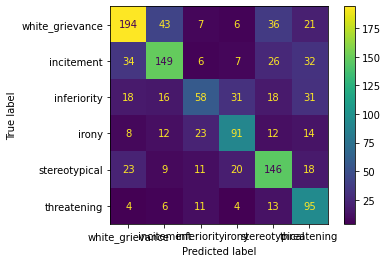

0.5803254700185463 0.5714452216481555 0.5676309723608268
Validation accuracy: 0.5849960095770151

======== Epoch 2 / 3 ========
Training...
Total loss: 520.5967365801334


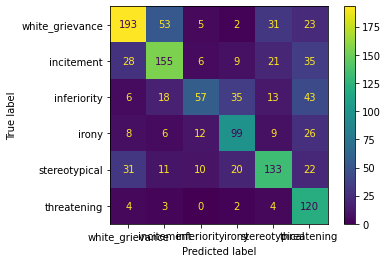

0.6128674645369736 0.6079120380080395 0.5889862370149436
Validation accuracy: 0.6041500399042299

======== Epoch 3 / 3 ========
Training...
Total loss: 404.11693301796913


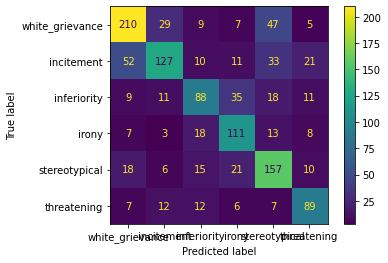

0.6250366472004317 0.6196108448617904 0.6178285031027344
Validation accuracy: 0.6241021548284118

Training complete!


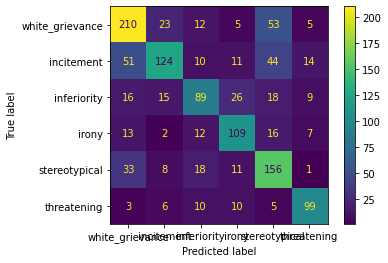

0.6335963647170483 0.6385843008404235 0.6307482782272565
Test accuracy: 0.6275917065390749


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▇▇▆▇▆▅▆▇▅▅▅▅▆▆▇▄▅▂▄█▅▆▇▃▄▂▃▃▂▃▃▂▁▂▃▂▂▄▅
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▄█
val_f1,▁▄█
val_precision,▁▆█


wandb: Agent Starting Run: j1iqf8o4 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 692.3206787109375


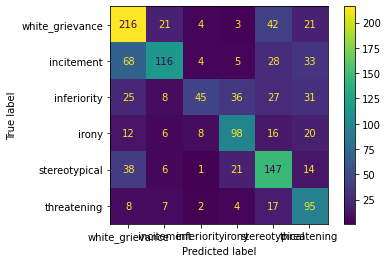

0.5660444481747583 0.5934059055015375 0.551266925893232
Validation accuracy: 0.5722266560255387

======== Epoch 2 / 3 ========
Training...
Total loss: 500.3037528991699


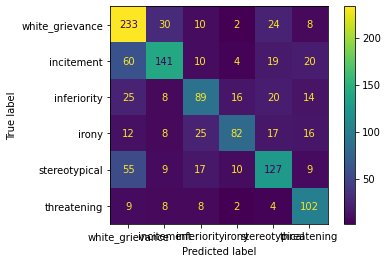

0.6117343807160521 0.6257730064693513 0.6113096265884648
Validation accuracy: 0.6177174780526736

======== Epoch 3 / 3 ========
Training...
Total loss: 382.1105737090111


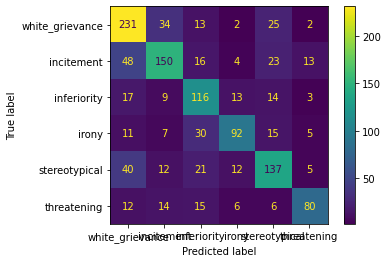

0.6329067951615971 0.655596699062253 0.6396653043581244
Validation accuracy: 0.6432561851556265

Training complete!


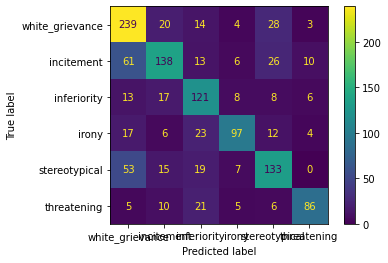

0.6435475993402838 0.6727542514152506 0.6517668128414602
Test accuracy: 0.6491228070175439


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,███▇▇▇▅▆▇▆▃▅▇▂▄▅▅▆▅▆▄▅▄▄▆▃▂▄▁▄▄▁▁▅▂▁▃▂▁▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▅█
val_f1,▁▆█
val_precision,▁▆█


wandb: Agent Starting Run: vwi9tv8o with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 1e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 687.544470667839


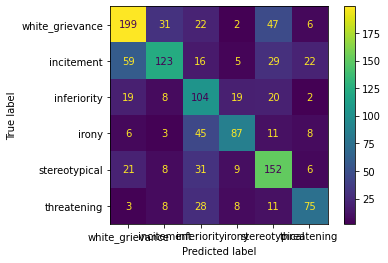

0.5857291498358623 0.6021627567969071 0.5863735802159828
Validation accuracy: 0.5905826017557861

======== Epoch 2 / 3 ========
Training...
Total loss: 488.27638760209084


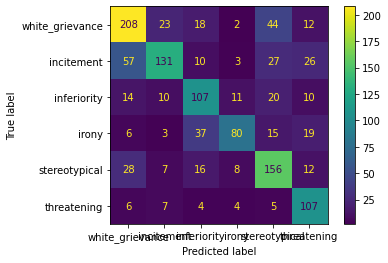

0.6345169054197194 0.6388942351942106 0.6256979912377899
Validation accuracy: 0.6296887470071828

======== Epoch 3 / 3 ========
Training...
Total loss: 380.7131758183241


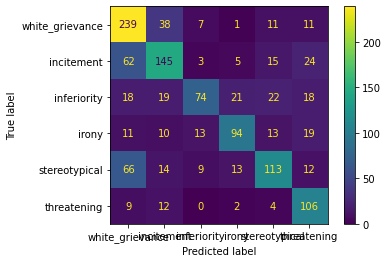

0.6103150277612525 0.630230504986797 0.6071099808923791
Validation accuracy: 0.6153232242617718

Training complete!


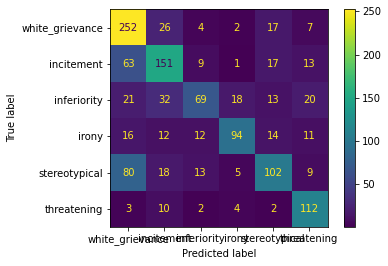

0.6156922294256411 0.6410287825971893 0.6145392922423081
Test accuracy: 0.6220095693779905


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,███▇▇▇▇▆▅▇▅▆▅█▄▆▇▄▅▅▂▄▅▄▇▆▃▄▃▄▂▅▃▂▃▃▅▂▁▂
epoch,▁▁▁
loss,█▃▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▅
val_f1,▁█▅
val_precision,▁█▅


wandb: Agent Starting Run: l9v6ff7e with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 653.3723548054695


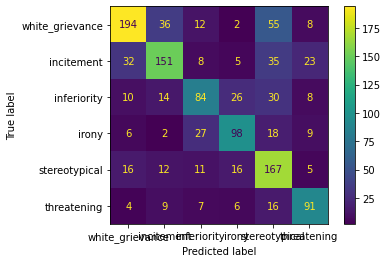

0.624529241967153 0.6285066814718837 0.6216314268830625
Validation accuracy: 0.6264964086193137

======== Epoch 2 / 3 ========
Training...
Total loss: 463.99893245100975


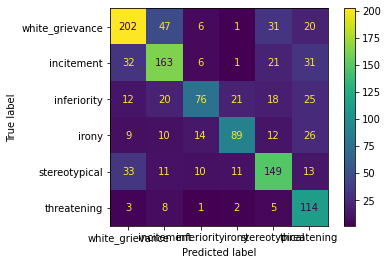

0.635225621158 0.639540100452712 0.6237367279719858
Validation accuracy: 0.6328810853950518

======== Epoch 3 / 3 ========
Training...
Total loss: 335.71230675280094


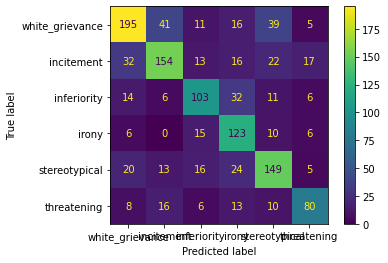

0.6444928332653246 0.6410563698001625 0.6386432898191919
Validation accuracy: 0.641660015961692

Training complete!


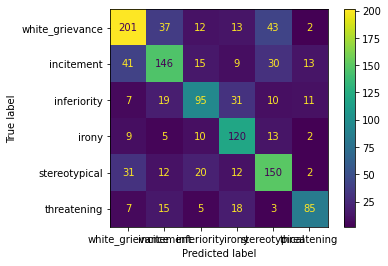

0.6385235295359014 0.6401257162749809 0.6364000904375015
Test accuracy: 0.6355661881977671


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▇█▆▇▅▅▅█▅▄▄▅▄▅▅▃▅▁▅▇▅▆▇▃▂▂▃▂▂▃▂▁▁▃▂▂▁▄▄
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▄█
val_f1,▁▂█
val_precision,▁▅█


wandb: Agent Starting Run: uz7o6of2 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 669.3854538798332


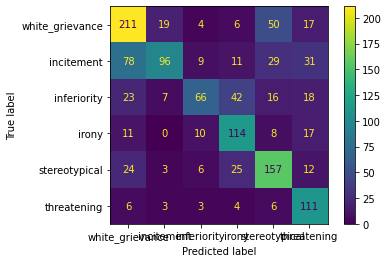

0.6146144208647885 0.6191033416354851 0.5920864959684268
Validation accuracy: 0.6025538707102953

======== Epoch 2 / 3 ========
Training...
Total loss: 479.9099390208721


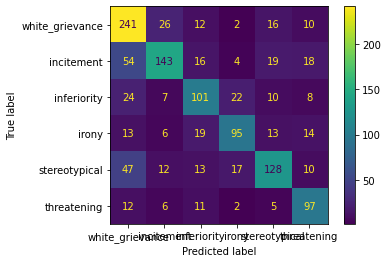

0.6370279458679734 0.645930522707487 0.6363757405910361
Validation accuracy: 0.6424581005586593

======== Epoch 3 / 3 ========
Training...
Total loss: 349.58665768802166


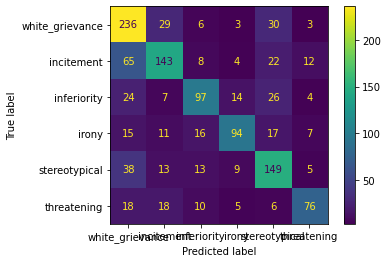

0.6184985821128275 0.6541079384216809 0.6307647159218445
Validation accuracy: 0.6344772545889864

Training complete!


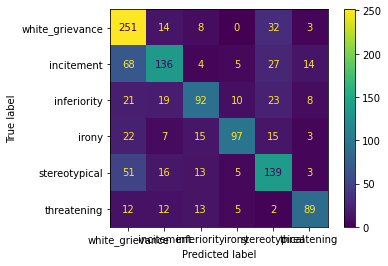

0.6289551117483935 0.6687533179844389 0.6415263003077033
Test accuracy: 0.6411483253588517


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▇█▆▆▇▅▆▆▅▄▅▆▂▄▄▅▆▅▆▄▆▂▅▅▂▂▄▃▃▅▄▁▅▂▁▃▁▂▁
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▇
val_f1,▁█▇
val_precision,▁█▂


wandb: Agent Starting Run: cvp7ryq8 with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 2e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 649.9003567099571


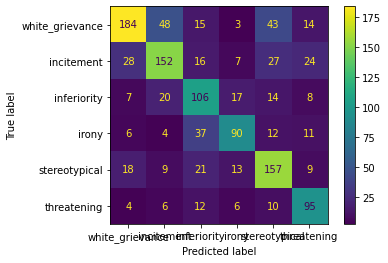

0.6304114118421068 0.623630803687986 0.6225737467493161
Validation accuracy: 0.6256983240223464

======== Epoch 2 / 3 ========
Training...
Total loss: 452.8188076019287


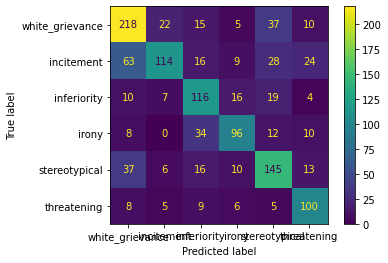

0.6373302402050957 0.6372821185613792 0.6285767545188812
Validation accuracy: 0.6296887470071828

======== Epoch 3 / 3 ========
Training...
Total loss: 329.71787260472775


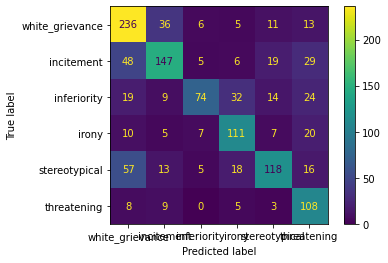

0.6338843701746478 0.6476514948284192 0.6234619109660285
Validation accuracy: 0.6336791699920191

Training complete!


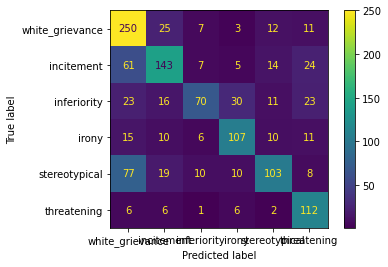

0.624685074420324 0.643260248665994 0.6165355895902793
Test accuracy: 0.6259968102073366


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,█▇▇▆▆▇▅▅▄▆▄▆▅█▄▆█▅▅▅▃▄▄▄▆▅▂▃▂▅▂▄▂▁▄▂▄▁▁▁
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▅█
val_f1,▁█▂
val_precision,▁█▅


wandb: Agent Starting Run: fs70suqf with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 638.7669968008995


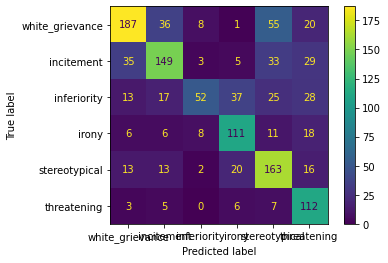

0.6253295354938398 0.6287629749176674 0.6027196876529911
Validation accuracy: 0.6177174780526736

======== Epoch 2 / 3 ========
Training...
Total loss: 457.3641279041767


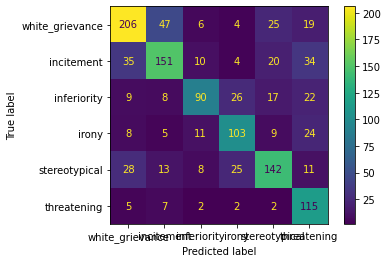

0.6537860149741878 0.644978309824867 0.6390741363971219
Validation accuracy: 0.6440542697525937

======== Epoch 3 / 3 ========
Training...
Total loss: 326.07014951109886


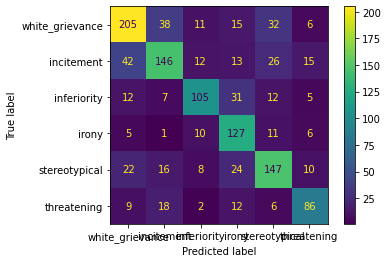

0.6568273904577513 0.653757435514832 0.6512192980583819
Validation accuracy: 0.6512370311252993

Training complete!


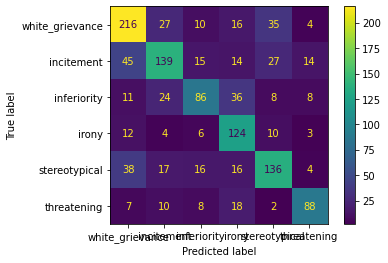

0.6310499857137646 0.6333534458821516 0.6271469575922186
Test accuracy: 0.6291866028708134


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▆█▆▇▆▅▅█▄▄▅▅▄▆▄▃▄▁▄▇▆▅▇▃▂▂▃▁▂▂▂▁▂▂▂▂▁▅▅
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▇█
val_f1,▁▆█
val_precision,▁▇█


wandb: Agent Starting Run: rtbq2zui with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 659.0717263817787


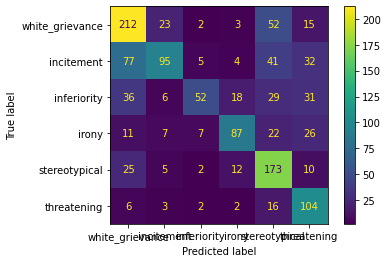

0.5757857500030271 0.6151711643659549 0.5601890147413077
Validation accuracy: 0.5770151636073424

======== Epoch 2 / 3 ========
Training...
Total loss: 472.47149607539177


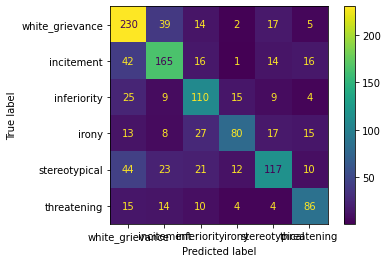

0.6167269823736664 0.6349678950444526 0.6201206342423032
Validation accuracy: 0.6288906624102155

======== Epoch 3 / 3 ========
Training...
Total loss: 348.526338070631


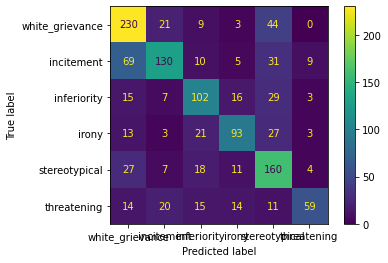

0.5972874641204681 0.6400812771562712 0.6062772848225166
Validation accuracy: 0.6177174780526736

Training complete!


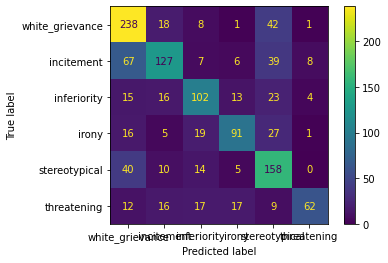

0.5994750580499261 0.6526400300974425 0.611984773496458
Test accuracy: 0.620414673046252


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▇█▆▆▆▄▅▆▄▄▅▇▃▅▄▅█▅▇▅▆▃▄▅▃▂▄▃▅▄▄▁▅▄▂▄▃▂▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▆
val_f1,▁█▆
val_precision,▁█▅


wandb: Agent Starting Run: ytz38f5k with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 3e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 662.4809684157372


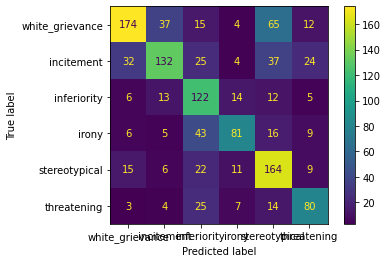

0.6043305548336779 0.6114824115929477 0.5965922319092486
Validation accuracy: 0.6009577015163607

======== Epoch 2 / 3 ========
Training...
Total loss: 466.88271337747574


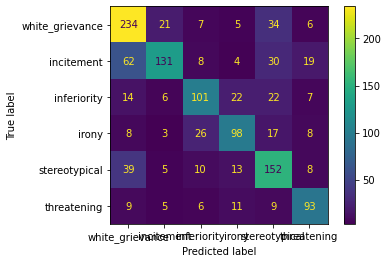

0.6410873270108043 0.6534202599381501 0.6413600603916699
Validation accuracy: 0.6456504389465283

======== Epoch 3 / 3 ========
Training...
Total loss: 328.85802211612463


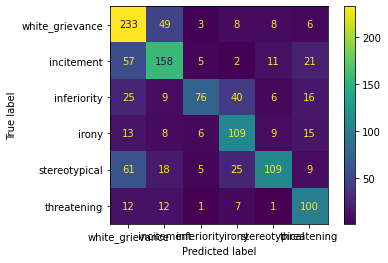

0.6226952124392932 0.6535314600389276 0.6204589799184749
Validation accuracy: 0.6264964086193137

Training complete!


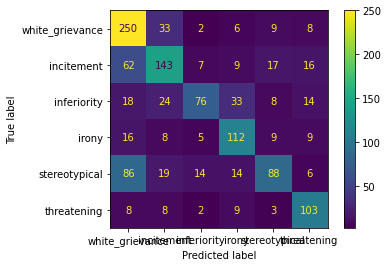

0.613415100040131 0.6371113791075863 0.6089045492246478
Test accuracy: 0.6156299840510366


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▆▆▅▆▇▇▅▄▆▄▆▅█▄▅▇▄▄▅▃▃▄▄▆▅▂▃▂▄▁▃▂▁▃▂▃▂▁▁
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▅
val_f1,▁█▅
val_precision,▁█▄


wandb: Agent Starting Run: uqrgu8ls with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 37


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 651.0476801395416


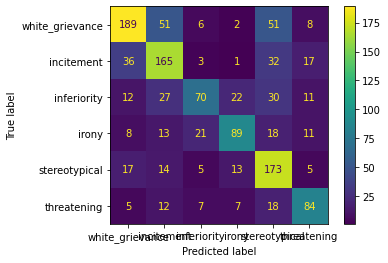

0.6036936178941824 0.6228441325940887 0.6045633767771451
Validation accuracy: 0.6145251396648045

======== Epoch 2 / 3 ========
Training...
Total loss: 477.2082556784153


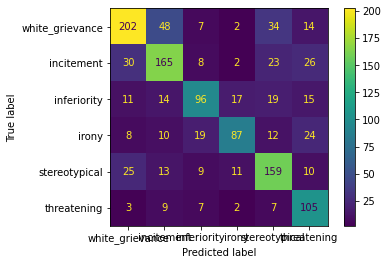

0.6498984171612109 0.6508073083986529 0.643168301960709
Validation accuracy: 0.6496408619313647

======== Epoch 3 / 3 ========
Training...
Total loss: 345.98157023638487


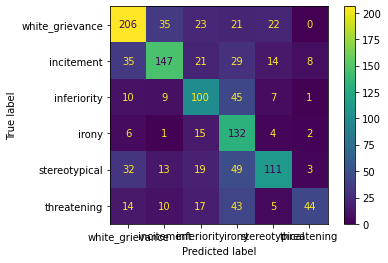

0.5793265216857728 0.6216341363412039 0.5713911024610753
Validation accuracy: 0.5905826017557861

Training complete!


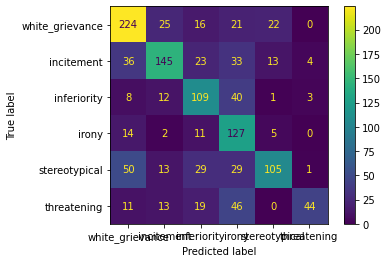

0.5867201574310777 0.6440822409458077 0.5806293947366082
Test accuracy: 0.6012759170653907


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▇▆█▆▇▅▄▃█▄▃▄▅▅▅▅▄▄▁▄▇▆▆▇▄▂▁▂▂▂▃▃▂▁▁▂▃▁▅▄
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▄█▁
val_f1,▄█▁
val_precision,▃█▁


wandb: Agent Starting Run: 3oh5svju with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 69


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 675.743061363697


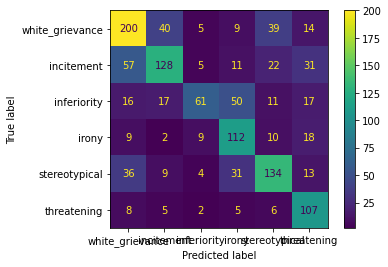

0.6008122694916429 0.6019967083313759 0.5832557178705401
Validation accuracy: 0.5921787709497207

======== Epoch 2 / 3 ========
Training...
Total loss: 488.23653930425644


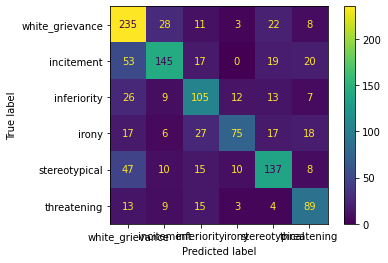

0.6147084553534422 0.6369754628118532 0.6176655723508028
Validation accuracy: 0.627294493216281

======== Epoch 3 / 3 ========
Training...
Total loss: 351.505308046937


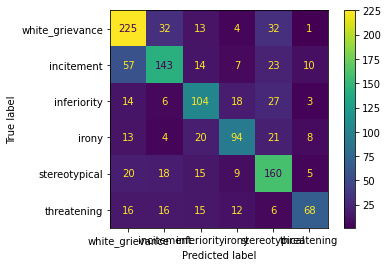

0.6173610536738247 0.6405150625712867 0.6240239850622568
Validation accuracy: 0.6336791699920191

Training complete!


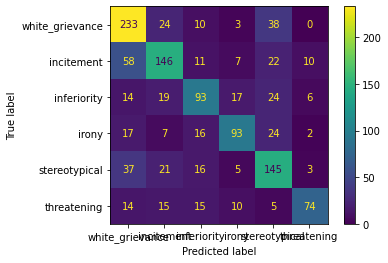

0.6081553446799702 0.6435777894871433 0.6202851829042411
Test accuracy: 0.6251993620414673


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,▆▆█▅▆▇▅▅▆▅▅▅▅▂▃▃▄█▅▆▃▅▃▄▆▃▂▃▂▅▄▃▁▄▂▂▃▃▂▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁▇█
val_f1,▁▇█
val_precision,▁▇█


wandb: Agent Starting Run: ptpuaz4v with config:
wandb: 	batch_size: 8
wandb: 	epochs: 3
wandb: 	epsilon: 1e-08
wandb: 	learning_rate: 4e-05
wandb: 	random_seed: 42


Some weights of the model checkpoint at ./bertweet_then_hsol_final were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at ./bertweet_then_hsol_final and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifie


======== Epoch 1 / 3 ========
Training...
Total loss: 660.3292379379272


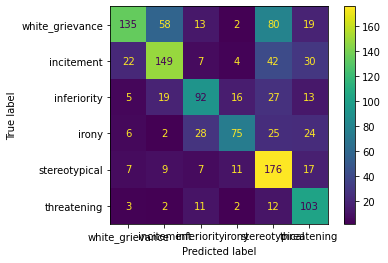

0.5966256324234493 0.6053570727949897 0.5799312542010624
Validation accuracy: 0.5826017557861133

======== Epoch 2 / 3 ========
Training...
Total loss: 467.96207270026207


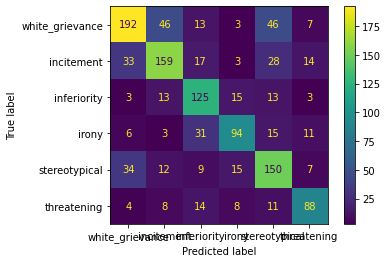

0.6480137818364983 0.6486907028706025 0.6456872597922059
Validation accuracy: 0.644852354349561

======== Epoch 3 / 3 ========
Training...
Total loss: 339.2368875220418


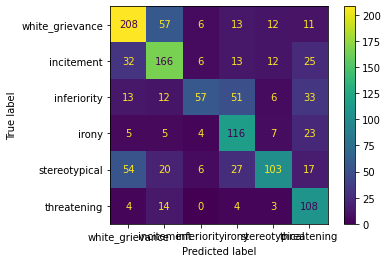

0.6088729424118817 0.6202364945288096 0.5881290306518047
Validation accuracy: 0.6049481245011972

Training complete!


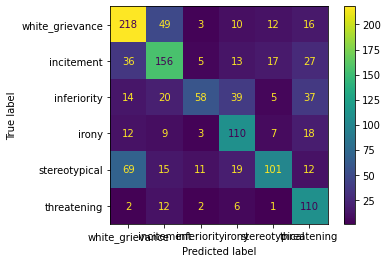

0.603508506832408 0.6151283640816855 0.5849147728364653
Test accuracy: 0.6004784688995215


batch,▁▂▂▃▃▄▄▅▅▆▆▇▇▁▂▂▃▃▄▄▅▅▆▆▇▇▁▁▂▂▃▄▄▅▅▆▆▇▇█
batch_loss,█▇▆▆▆▇▆▅▄▆▄▆▅█▃▆▇▄▅▅▂▃▄▄▅▅▁▃▃▄▁▆▂▂▄▂▃▁▁▂
epoch,▁▁▁
loss,█▄▁
test_acc,▁
test_f1,▁
test_precision,▁
test_recall,▁
val_acc,▁█▄
val_f1,▁█▂
val_precision,▁█▃


In [20]:
count = 12 # number of runs to execute
wandb.agent(sweep_id, function=train, count=count, entity="umass-iesl-is", project="bertweet-sarc-implicit")